# Laboratorium 02 - Metoda najmniejszych kwadatów
## Błażej Naziemiec i Szymon Żuk
### 18 marca 2025

## Wstęp
Celem zadania jest zastosowanie metody najmniejszych kwadratów do predykcji, czy nowotwór jest złośliwy (ang. $\textit{malignant}$)
czy łagodny (ang. $\textit{benign}$).
Nowotwory złośliwe i łagodne mają różne charakterystyki wzrostu. Istotne cechy to m. in. promień i tekstura.
Charakterystyki te wyznaczane są poprzez diagnostykę obrazową i biopsje.

Na początku zaczytaliśmy dane z przygotowanych plików .dat i wrzuciliśmy je na histogram oraz wykres punktowy. W wykresie punktowym zgodnie z poleceniem posortowaliśmy wartośc kolumny od najmniejszej do największej. Wybraliśmy $\textit{symmetry (mean)}$ do przedstawienia na historgramie oraz wykresie.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
with open("dataset/breast-cancer.labels", "r") as f:
    labels = [line.strip() for line in f.readlines()]
train_data = pd.io.parsers.read_csv("dataset/breast-cancer-train.dat", names=labels)
validate_data = pd.io.parsers.read_csv("dataset/breast-cancer-validate.dat", names=labels)
train_data_malignant = train_data[train_data["Malignant/Benign"] == "M"]
train_data_benign = train_data[train_data["Malignant/Benign"] == "B"]

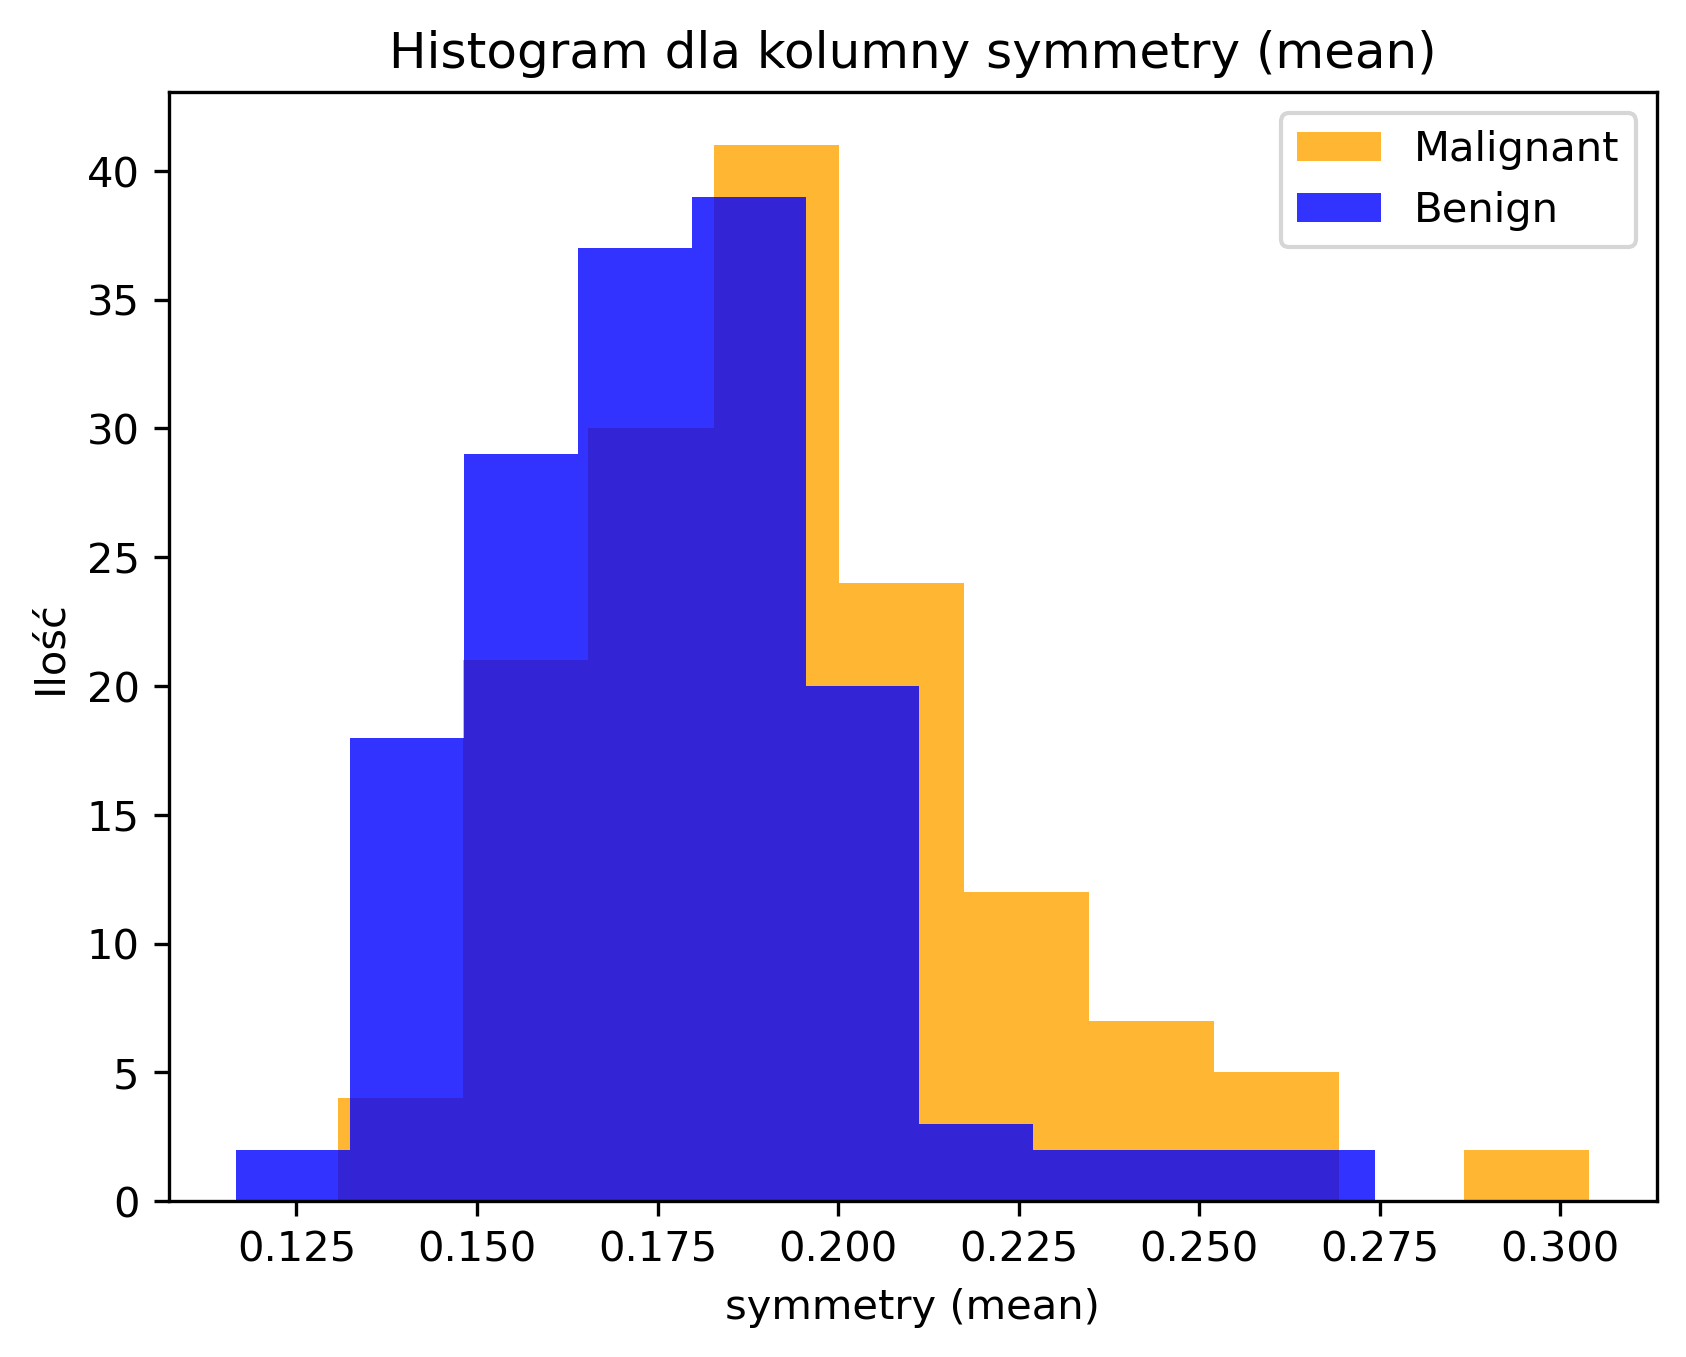

In [3]:
test_column = 10
test_column_name = labels[test_column]
plt.figure(dpi=300)
plt.hist(train_data_malignant[labels[test_column]], alpha=0.8, label='Malignant', color='orange')
plt.hist(train_data_benign[labels[test_column]], alpha=0.8, label='Benign', color='blue')
plt.xlabel(test_column_name)
plt.ylabel("Ilość")
plt.title(f"Histogram dla kolumny {test_column_name}")
plt.legend()
plt.show()

*Rysunek 1. Histogram dla cechy $\textit{symmetry (mean)}$*

Rozkład dla nowotworów złośliwych jest przesunięty w prawo, co wskazuje, że złośliwe guzy nowotworowe zazwyczaj są bardziej symetryczne niż łagodne. Największa koncentracja dla nowotowrów złośliwych jest w okolicach 0.200, a dla łagodnych w okolicach 0.180.  

In [4]:
sorted_train_data_malignant = train_data_malignant[labels[test_column]].sort_values().reset_index(drop=True)
sorted_train_data_benign = train_data_benign[labels[test_column]].sort_values().reset_index(drop=True)

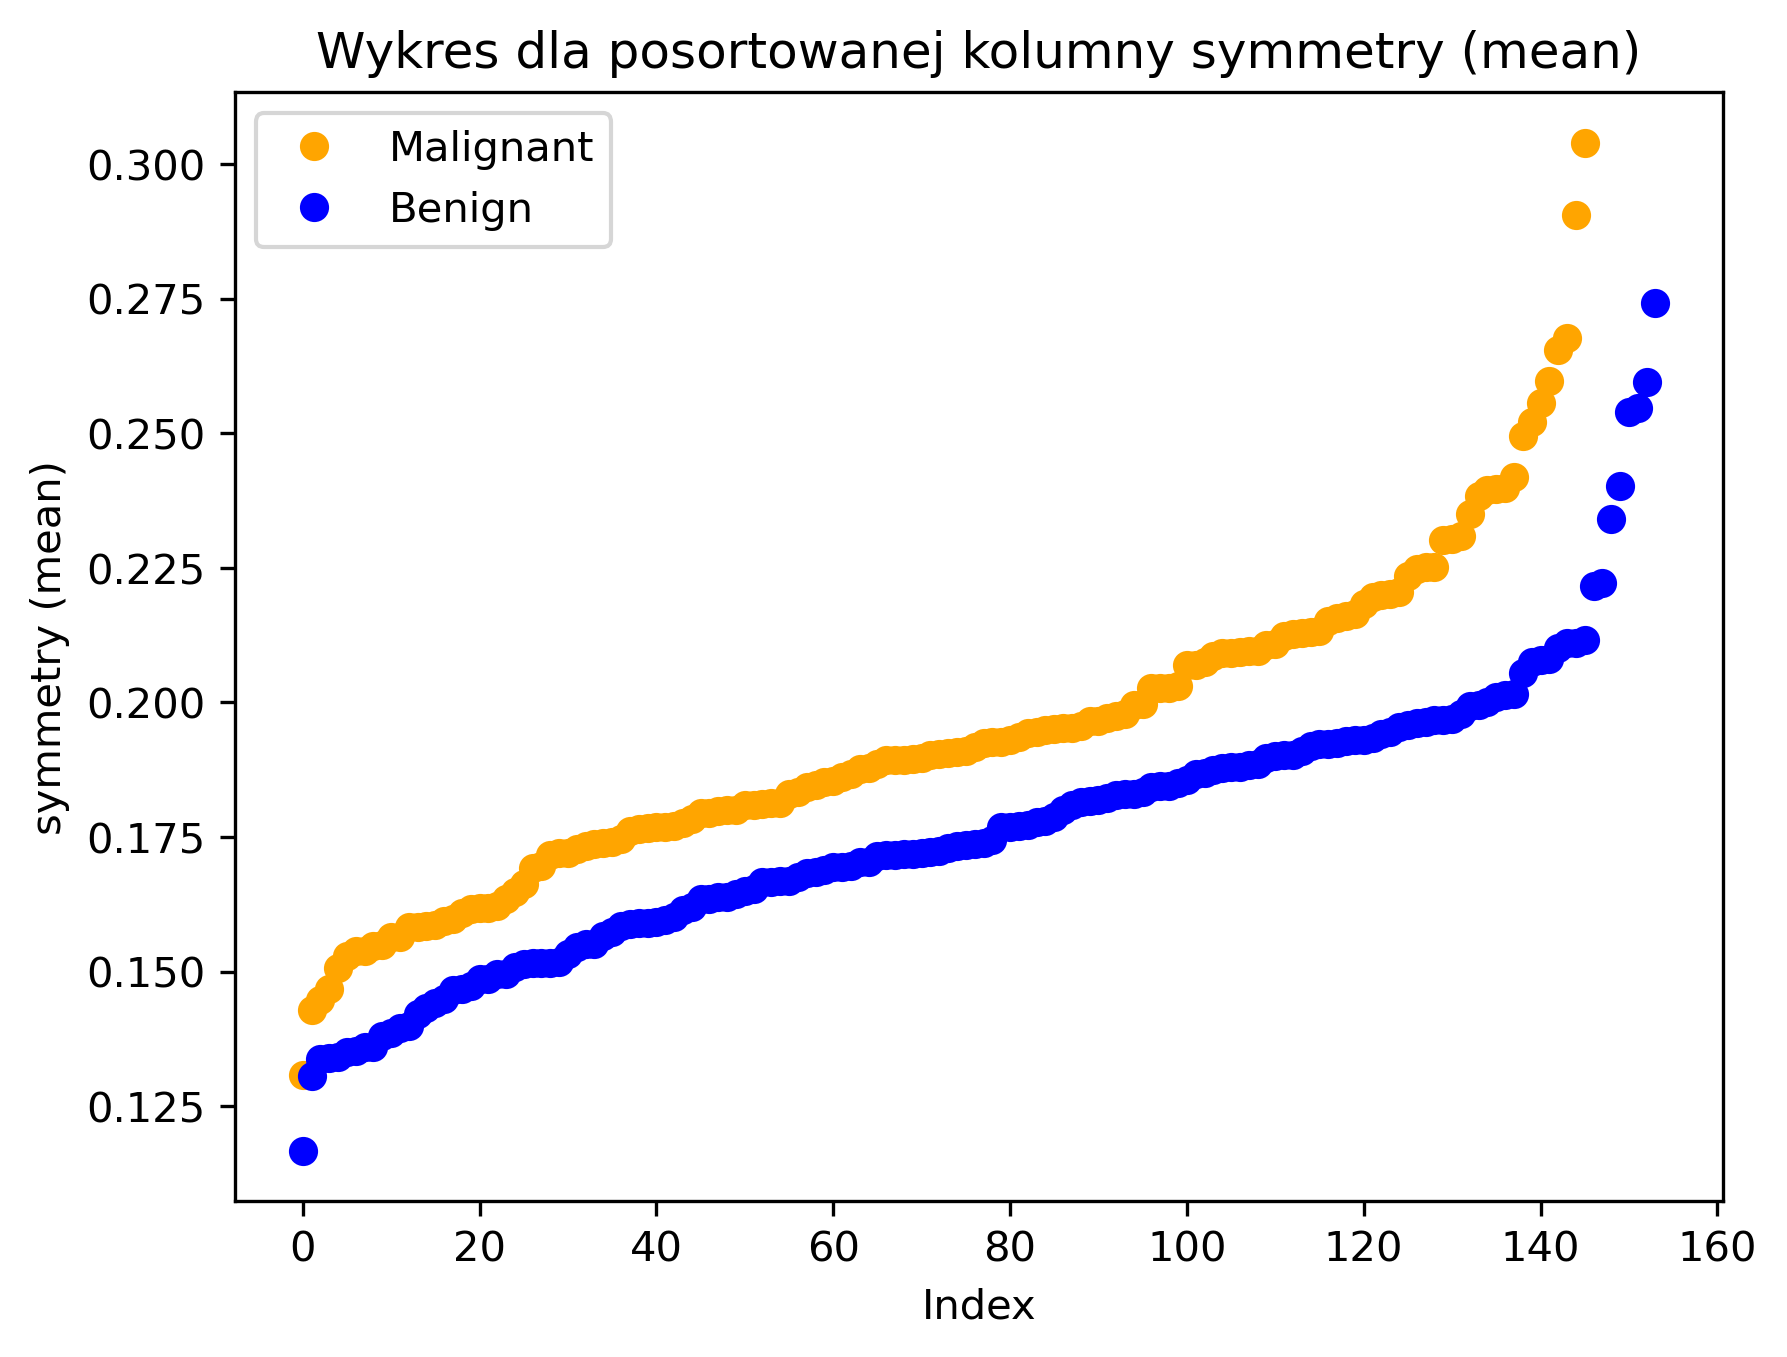

In [5]:
test_column = 10
test_column_name = labels[test_column]
plt.figure(dpi=300)
plt.plot(range(len(sorted_train_data_malignant)), sorted_train_data_malignant.values, 'o', label='Malignant', color='orange')
plt.plot(range(len(sorted_train_data_benign)), sorted_train_data_benign.values, 'o', label='Benign', color='blue')
plt.ylabel(test_column_name)
plt.xlabel("Index")
plt.title(f"Wykres dla posortowanej kolumny {test_column_name}")
plt.legend()
plt.show()

*Rysunek 2 Wykres punktowy dla cechy $\textit{symmetry (mean)}$*

Dane dla nowotworów złośliwych (pomarańczowe punkty) są generalnie wyżej na wykresie niż dane dla nowotworów łagodnych, co potwierdza wcześniejszą obserwację, że złośliwe guzy nowotorowe są bardziej symetryczne niż łagodne.

## Macierze dla liniowej i kwadratowej metody najmniejszych kwadratów

### Przygotowanie danych

Stworzyliśmy reprezentacje danych zawartych w obu zbiorach dla liniowej i kwadratowej metody najmniejszych kwadratów. W następnym kroku stworzyliśmy wektor $b$ dla zbiorów nowotworów łagodnych oraz złośliwych. Następnie znaleźliśmy wagi dla liniowej oraz kwadratowej reprezentacji najmniejszych kwadratów
przy pomocy wcześniej stworzonych macierzy i wektora $b$ z zbioru danych treningowych. Znaleźliśmy też zbiór wag przy użyciu funkcji `np.linalg.lstsq` z $$ \lambda  = 0.01 $$

In [6]:
linear_train = train_data.drop(["patient ID", "Malignant/Benign"], axis=1).values
linear_validate = validate_data.drop(["patient ID", "Malignant/Benign"], axis=1).values

def create_quadratic_representation(data):
    df = data.copy()
    for i in range(len(quad_columns)):
        df[f"{i}^2"] = data[quad_columns[i]] ** 2
    for i in range(len(quad_columns)):
        for j in range(i + 1, len(quad_columns)):
            df[f"{i}_{j}"] = data[quad_columns[i]] * data[quad_columns[j]]
    return df.values

quad_columns = ["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]
quadratic_train = create_quadratic_representation(train_data[quad_columns])
quadratic_validate = create_quadratic_representation(validate_data[quad_columns])

In [7]:
b_training = np.where(train_data[['Malignant/Benign']] == "M", 1, -1)
b_validate = np.where(validate_data[['Malignant/Benign']] == "M", 1, -1)

In [8]:
cov_mat_lin = linear_train.T @ linear_train
cov_mat_quad = quadratic_train.T @ quadratic_train

In [9]:
weights_linear = np.linalg.solve(cov_mat_lin, linear_train.T @ b_training)
weights_quadratic = np.linalg.solve(cov_mat_quad, quadratic_train.T @ b_training)

In [14]:
λ = 0.01
svd = scipy.linalg.lstsq(cov_mat_lin + λ * np.eye(cov_mat_lin.shape[0]), linear_train.T @ b_training)

### Wyznaczenie współczynnika uwarunkowania macierzy dla liniowej i kwadratowej metody najmniejszych kwadratów

Za pomocą funkcji `np.linalg.cond` wyznaczyliśmy współczynnik uwarunkowania macierzy dla liniowej i kwadratowej metody najmniejszych kwadratów. Dla poszczególnych metod otrzymaliśmy następujące wyniki:

  - Dla liniowej metody najmniejszych kwadratów: $1.8092 * 10^{12}$
  - Dla kwadratowej metody najmniejszych kwadratów: $9.0568 * 10^{17}$
  - Dla macierzy do metody SVD: $5.29336 * 10^{10}$ 

Wartości zarówno dla liniowej, jak i kwadratowej metody najmniejszych kwadratów są duże, co oznacza, że macierze są źle uwarunkowane. Wartości dla macierzy kwadartowej są bardzo wysokie. Najlepszy wyniki osiągneliśmy dla metody SVD, gdzie współczynnik uwarunkowania macierzy był najmniejszy. Przez to, że macierze są źle uwarunkowe, wagi nie będą dokładne.

In [24]:
cond_lin = np.linalg.cond(cov_mat_lin)
cond_quad = np.linalg.cond(cov_mat_quad)
cond_svd = np.linalg.cond(cov_mat_lin + λ * np.eye(cov_mat_lin.shape[0]))

In [26]:
p_lin = linear_validate @ weights_linear
p_quad = quadratic_validate @ weights_quadratic
p_svd = linear_validate @ svd[0]

## Sprawdzenie, jak dobrze otrzymane wagi przewidują typ nowotworu

Dla poszczególnych metod przedstawiamy wyniki klasyfikacji dla danych testowych. W tabeli przedstawiamy wartości TP, TN, FP, FN oraz dokładność klasyfikacji.

  - TP - liczba przypadków prawdziwie dodatnich
  - TN - liczba przypadków prawdziwie ujemnych
  - FP - liczba przypadków fałszywie dodatnich 
  - FN - liczba przypadków fałszywie ujemnych
  - Accuracy - dokładność klasyfikacji ($\frac{TP + TN}{TP + TN + FP + FN}$)

| TP | TN | FP | FN | Accuracy |
|-------|------|-------|------|----------|
| 58     | 194    | 6     | 2    | 96.92%      |

*Tabela 1. Wyniki klasyfikacji dla liniowej metody najmniejszych kwadratów*

| TP | TN | FP | FN | Accuracy |
|-------|------|-------|------|----------|
| 55     | 185    | 15     | 5    | 92.31%      |

*Tabela 2. Wyniki klasyfikacji dla kwadratowej metody najmniejszych kwadratów*

| TP | TN | FP | FN | Accuracy |
|-------|------|-------|------|----------|
| 55     | 199    | 1     | 5    | 97.69%      |

*Tabela 3. Wyniki klasyfikacji dla macierzy do metody SVD metody najmniejszych kwadratów*

Porównując wyniki przedstawione w tabelach $(1)$, $(2)$ oraz $(3)$ można zauważyć, że najlepsze wyniki zwraca metoda SVD, a liniowa metoda najmniejszych kwadratów daje lepsze wyniki klasyfikacji niż kwadratowa metoda najmniejszych kwadratów. Dokładność klasyfikacji dla macierzy do metody SVD wynosi $97.69\%$, liniowej metody $96.92\%$, a dla kwadratowej $92.31\%$. Warto jednak zauważyć, że poprawność wyników wszystkich metod jest bardzo wysoka. Świadczy to o poprawności zaimplementowanych rozwiązań.


In [28]:
def calc_acc(p_vec, b_vec):
    tp = np.sum([1 for p, b in zip(p_vec, b_vec) if p > 0 and b > 0])
    tn = np.sum([1 for p, b in zip(p_vec, b_vec) if p <= 0 and b < 0])
    fp = np.sum([1 for p, b in zip(p_vec, b_vec) if p > 0 and b <= 0])
    fn = np.sum([1 for p, b in zip(p_vec, b_vec) if p <= 0 and b > 0])
    return int(tp), int(tn), int(fp), int(fn), float((tp + tn) / (tp + tn + fp + fn))

tp_lin, tn_lin, fp_lin, fn_lin, acc_lin = calc_acc(p_lin, b_validate)
tp_quad, tn_quad, fp_quad, fn_quad, acc_quad = calc_acc(p_quad, b_validate)
tp_svd, tn_svd, fp_svd, fn_svd, acc_svd = calc_acc(p_svd, b_validate)

## Bibliografia

 - Materiały zamieszczone na platformie Microsoft Teams w zespole $\textit{MOwNiT 2025}$ w zakładce $\textit{Materiały z zajęć/lab02/lab-intro02.pdf}$